In [1]:
#function to generate images with only path specification required
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


def imggen(im_path):
    img=mpimg.imread(im_path)
    plt.axis("off")
    plt.imshow(img)
    plt.show()

In [4]:
from sklearn.datasets import fetch_openml

mnist= fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [5]:
# x,y= mnist['data'], mnist['target']
X,y=mnist.data, mnist.target
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


In [6]:
X = mnist.data.to_numpy()
y = mnist.target.to_numpy().astype(int)


In [7]:
type(X)

numpy.ndarray

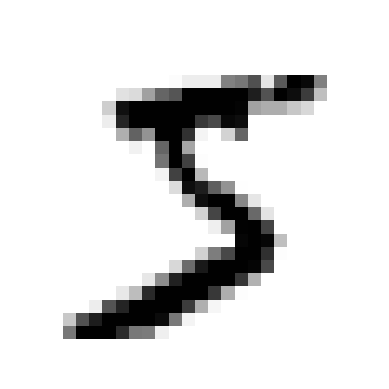

In [8]:
import matplotlib as mtp
import matplotlib.pyplot as plt

some_digit=X[0]
some_digit_image=some_digit.reshape(28,28)
plt.imshow(some_digit_image,cmap='binary')
plt.axis('off')  # Fixed: this should be a function call, not assignment
plt.show()

In [9]:
y[0]

np.int64(5)

In [10]:
X_train,X_test,y_train,y_test= X[:60000],X[60000:],y[:60000],y[60000:]

training a sgd classifier to classify just 1 digit- 5

In [11]:
y_train_5= (y_train==5)
y_test_5=(y_test==5)

In [12]:
from sklearn.linear_model import SGDClassifier
sgd_clf= SGDClassifier(random_state=42) #random state is set for reproducible results
sgd_clf.fit(X_train,y_train_5)


,loss,'hinge'
,penalty,'l2'
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,1000
,tol,0.001
,shuffle,True
,verbose,0
,epsilon,0.1
,n_jobs,None


In [13]:
sgd_clf.predict([some_digit])

array([ True])

|| works correctly ||

In [14]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds=StratifiedKFold(n_splits=3)
for train_index, test_index in skfolds.split(X_train,y_train_5):
    sgd_clf_pred=clone(sgd_clf)
    X_train_split=X_train[train_index]
    y_train_5_split=y_train_5[train_index]
    X_test_split=X_train[test_index]
    y_test_5split=y_train_5[test_index]

    sgd_clf_pred.fit(X_train_split,y_train_5_split)
    y_pred= sgd_clf_pred.predict(X_test_split)
    right= sum(y_pred==y_test_5split)
    accuracy= right/len(y_pred)
    print(accuracy)

0.95035
0.96035
0.9604


In [15]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf,X_train,y_train_5,cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

BaseEstimator is a base class in scikit-learn (sklearn) that gives structure and convenience methods to all estimators — models, transformers, etc.

Let’s break it down simply:


In sklearn, almost every model you use — like LinearRegression, RandomForestClassifier, StandardScaler, etc. — inherits from BaseEstimator. It ensures that all these models behave consistently.


Here’s what it mainly provides:
Parameter handling
It gives you built-in get_params() and set_params() methods.
So when you do things like grid search or pipeline tuning, sklearn can easily read and modify parameters because BaseEstimator standardizes how they're stored.


A common interface
Every sklearn estimator must have .fit() and often .predict(), .transform(), or .score().
BaseEstimator doesn’t implement these methods itself — it just ensures subclasses follow the same pattern.

In [16]:
from sklearn.base import BaseEstimator
import numpy as np

class Never5classifier(BaseEstimator):
    def fit(self,X,y=None):
        return self
    def predict(self, X, y=None):
        return np.zeros((len(X),1),dtype=bool)

In [17]:
never5=Never5classifier()
cross_val_score(never5,X_train,y_train_5,cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

as we see we got 90% accuracy over sth that just labels not 5, its cause only 10% of the data has 5 as label, so if all are not 5, we still get high accuracy, this is why 'accuracy' is not a good performance metric, especially for skewed datasets

In [18]:
# CONFUSION MATRIX- A better way to look at the performante
from sklearn.model_selection import cross_val_predict

y_train_pred=cross_val_predict(sgd_clf, X_train,y_train_5,cv=3)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5,y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [19]:
# # Visualize the confusion matrix directly
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.metrics import confusion_matrix

# # Assuming y_train_5 and y_train_pred are already defined in your code
# # y_train_5 should be the true labels
# # y_train_pred should be the predicted labels from your model

# # Get the confusion matrix from the previous cell
# cm = confusion_matrix(y_train_5, y_train_pred)

# # Create a heatmap
# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
#             xticklabels=['Not 5', '5'], 
#             yticklabels=['Not 5', '5'])
# plt.title('Confusion Matrix')
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.show()

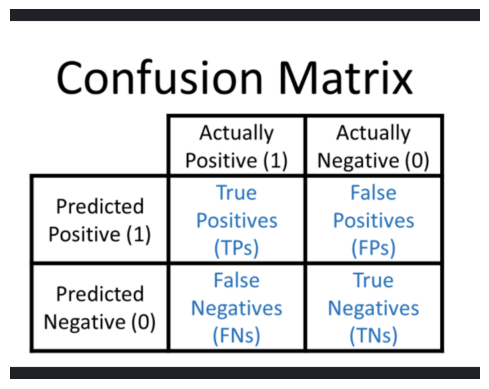

In [20]:
imggen('confusion.png')

### in a confusion matrix- 

a row represents an actual class and a column represents a predicted class


In [21]:
y_perfection=y_train_5
confusion_matrix(y_train_5,y_perfection)

array([[54579,     0],
       [    0,  5421]])

### precision= tp/tp+fp-- the total correct predicted positives out of total predicted positives


### recall= tp/fn+tp-- the total correct predicted positives out of total actual positives


### f1_score= 2/(1/p+1/r) harmonic mean of p and r so that lower values get mroe importance


The F1 score favors classifiers that have similar precision and recall. This is not always
what you want: in some contexts you mostly care about precision, and in other con‐
texts you really care about recall. For example, if you trained a classifier to detect vid‐
eos that are safe for kids, you would probably prefer a classifier that rejects many
good videos (low recall) but keeps only safe ones (high precision), rather than a clas‐
sifier that has a much higher recall but lets a few really bad videos show up in your
product (in such cases, you may even want to add a human pipeline to check the clas‐
sifier’s video selection). On the other hand, suppose you train a classifier to detect
shoplifters in surveillance images: it is probably fine if your classifier has only 30%
precision as long as it has 99% recall (sure, the security guards will get a few false
alerts, but almost all shoplifters will get caught).
Unfortunately, you can’t have it both ways: increasing precision reduces recall, and
vice versa. This is called the precision/recall trade-off.

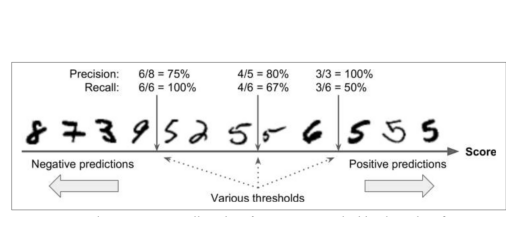

In [22]:
imggen('pr_tradeoff.png')

In [23]:
y_scores=sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [24]:
threshold=2165

In [25]:
y_predi=(y_scores>threshold)
y_predi
#we get false as sgd sets a threshold for classification and recall decreases as we increse the threshold
#as also the case here recall is 0}

array([False])

In [26]:
y_scores= cross_val_predict(sgd_clf, X_train,y_train_5, cv=3, method= 'decision_function')


In [27]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds= precision_recall_curve( y_train_5, y_scores)

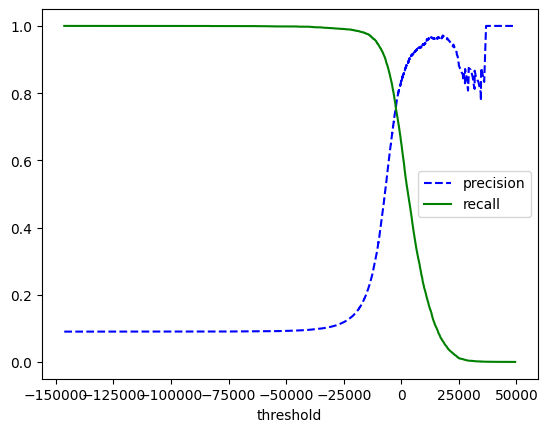

In [28]:
def plot_pr_thresholds(precision,recall,thresholds):
    plt.plot(thresholds, precision[:-1],'b--',label='precision') # -1 is for slicing the last element cause precisions and recalls each have one extra element compared to thresholds.

    plt.plot(thresholds, recall[:-1],'g-',label='recall' )
    plt.xlabel('threshold')
    # plt.ylabel('score')
    plt.legend(loc='right')

plot_pr_thresholds(precision, recall, thresholds)
plt.show()

why the precision line bumpy??

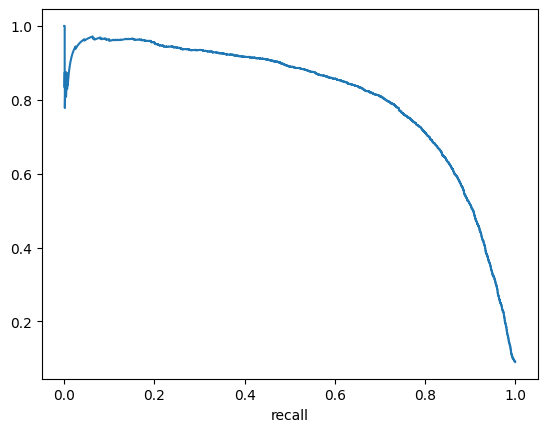

In [34]:
plt.plot( recall,precision)
plt.xlabel('recall')
plt.show()

In [ ]:
threshold_90_precision = thresholds[np.argmax(precision >= 0.90)] # ~7816
threshold_90_precision

np.float64(3370.019499144185)

In [41]:
type(thresholds)

numpy.ndarray

In [42]:
y_train_pred_90=(y_scores>=threshold_90_precision)

In [43]:
y_train_pred_90

array([False, False, False, ...,  True, False, False], shape=(60000,))

In [47]:
from sklearn.metrics import precision_score,recall_score

precision_score(y_train_5,y_train_pred_90)

0.9000345901072293

In [48]:
recall_score(y_train_5,y_train_pred_90)

0.4799852425751706

receiver operating characteristic (ROC) curve

In [49]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds= roc_curve(y_train_5, y_scores)


/var/folders/ql/hdbyk3lx6vq0x6fs9227fc_m0000gn/T/ipykernel_2778/3882347921.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


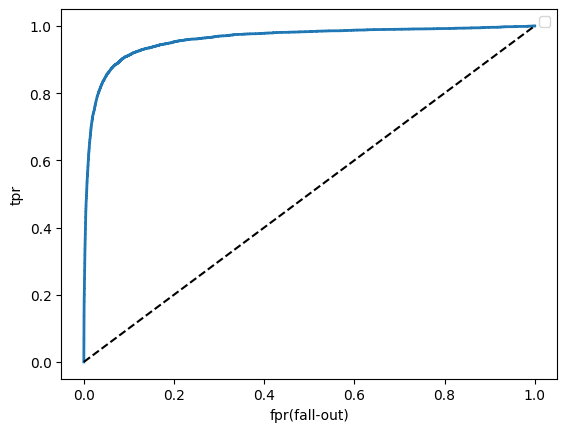

In [58]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, label=label, linewidth= 2)
    plt.plot([0,1],[0,1],'k--')

plot_roc_curve(fpr, tpr)
plt.xlabel('fpr(fall-out)')
plt.ylabel('tpr')
plt.legend()
plt.show()

In [60]:
#to compare classifiers we take the AUC of the ROC, a perfect classifier will have 1 auc and random will have 0.5
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [61]:
from sklearn.ensemble import RandomForestClassifier

rf_clf= RandomForestClassifier(random_state=42)
y_probas= cross_val_predict(rf_clf,X_train, y_train_5, cv=3, method='predict_proba')


y_probas_forest is usually a 2D array that contains the predicted probabilities for each class from a classifier (like RandomForestClassifier.predict_proba()).
For a binary classification problem, predict_proba() returns something like this:
[
  [0.85, 0.15],
  [0.10, 0.90],
  [0.60, 0.40],
  ...
]
Each row corresponds to one sample.
Each column corresponds to one class — specifically, the classes in the order given by model.classes_.
So:
[:, 0] → probabilities for class 0
[:, 1] → probabilities for class 1

In [66]:
y_scores_forest= y_probas[:,1]
fpr_forest, tpr_forest, forest_thresholds= roc_curve(y_train_5,y_scores_forest)

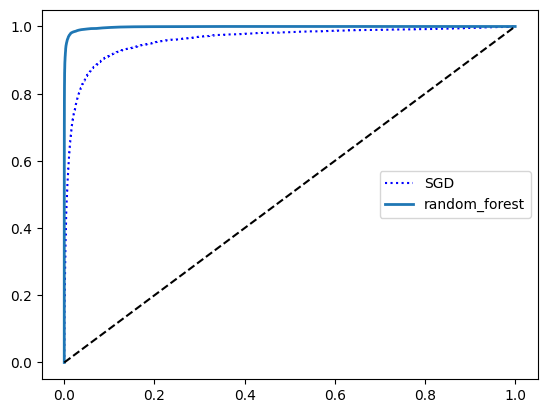

In [69]:
plt.plot(fpr, tpr,'b:',label='SGD')
plot_roc_curve(fpr_forest,tpr_forest, "random_forest")
plt.legend(loc='right')
plt.show()

In [71]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983296721818179

Multiclass classification distinguishes between more than two classes. Some algorithms (e.g., Random Forest, Naive Bayes) handle multiclass natively, while others (e.g., Logistic Regression, SVM) require strategies like:


One-vs-Rest (OvR): Train one binary classifier per class (e.g., 10 for digits 0–9). The class with the highest score is selected.


One-vs-One (OvO): Train a binary classifier for every pair of classes (e.g., 45 for digits 0–9). The class that wins the most pairwise comparisons is selected.


OvR is preferred for most algorithms, while OvO is better for algorithms that scale poorly with large datasets (e.g., SVM).


In [74]:
from sklearn.svm import SVC
svm_clf= SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5])

In [75]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [76]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

In [77]:
svm_train_predict= cross_val_predict(svm_clf, X_train, y_train, cv=3)

In [78]:
svm_train_predict

array([5, 0, 4, ..., 5, 6, 8], shape=(60000,))

In [80]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_train_scaled= scaler.fit_transform(X_train.astype(np.int64))
cross_val_score(svm_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.9596, 0.9602, 0.961 ])

In [81]:
y_train_pred= cross_val_predict(svm_clf, X_train_scaled,y_train,cv=3)
conf_mx=confusion_matrix(y_train,y_train_pred)
conf_mx

array([[5809,    3,   20,    8,    6,   13,   32,   14,   17,    1],
       [   1, 6620,   37,   12,   11,    0,    7,   31,   13,   10],
       [  20,   18, 5721,   42,   27,    4,   20,   61,   36,    9],
       [   3,   15,   83, 5778,    5,   64,    2,   87,   73,   21],
       [   5,   11,   45,    2, 5623,    6,   21,   25,   10,   94],
       [  14,   11,   16,   77,   17, 5134,   58,   50,   28,   16],
       [  20,    7,   22,    0,   13,   39, 5743,   55,   19,    0],
       [   9,   24,   37,   15,   39,    1,    0, 6070,    5,   65],
       [  19,   44,   42,   50,   20,   52,   26,   40, 5533,   25],
       [  11,   10,   25,   49,   81,   12,    1,  153,   22, 5585]])

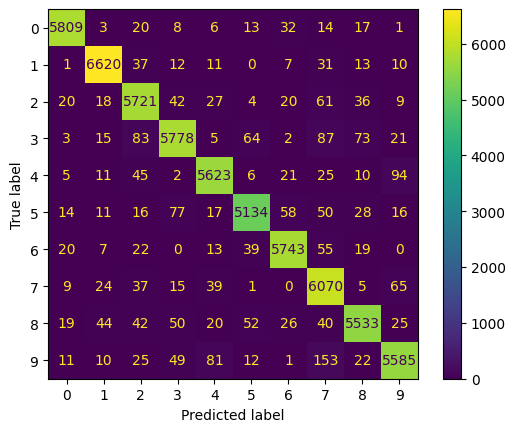

In [94]:
from sklearn.metrics import ConfusionMatrixDisplay

# plt.matshow(conf_mx, cmap=plt.cm.gray)
# plt.show()
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)


In [95]:
row_sums= conf_mx.sum(axis=1,keepdims=True)
norm_conf_mx=conf_mx/row_sums

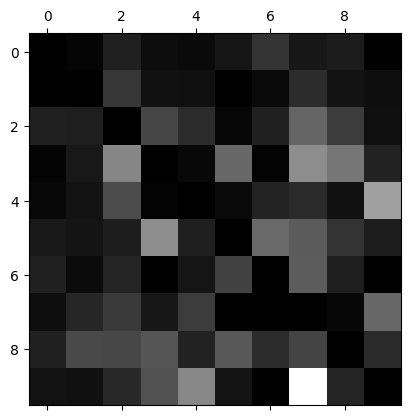

In [ ]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap= plt.cm.gray)
plt.show()


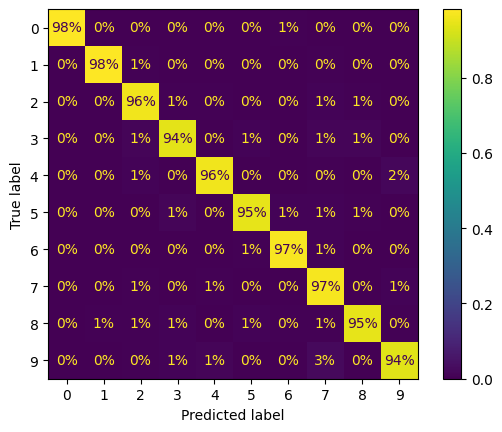

In [97]:
 # extra code
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                        normalize="true", values_format=".0%")
plt.show()

on a brief analysis of the conf_plot we can see the 7th column(predicted class) gets wrong a lot of the times meaning a lot of predictions get mislabeled as 7 so we should work on 7( like giving it more harder images for 7 that are not 7 to learn patterns)

Or you could engineer new features that would help the classifier—for example,
writing an algorithm to count the number of closed loops (e.g., 8 has two, 6 has one, 5
has none). Or you could preprocess the images (e.g., using Scikit-Image, Pillow, or
OpenCV) to make some patterns, such as closed loops, stand out more.

one way to reduce the 3/5 confusion
would be to preprocess the images to ensure that they are well centered and not too
rotated. This will probably help reduce other errors as well.

## multilabel classification system
Consider a face-
recognition classifier: what should it do if it recognizes several people in the same
picture? It should attach one tag per person it recognizes. 

In [86]:
from sklearn.neighbors import KNeighborsClassifier

y_large=(y_train>=7)
y_odd=(y_train%2==1)
y_multilabel= np.c_[y_large, y_odd]
knn=KNeighborsClassifier()
knn.fit(X_train,y_multilabel)

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [87]:
knn.predict([some_digit])

array([[False,  True]])

In [ ]:
from sklearn.metrics import f1_score
y_train_knn= cross_val_predict(knn, X_train, y_multilabel,cv=3)
f1_score(y_multilabel, y_train_knn,average='weighted' )

#average gave 0.9764102655606048 and weighted gave 0.9778357403921755

0.9778357403921755

In [93]:
noise=np.random.randint(0,100,(len(X_train),784))
X_train_mod= noise+ X_train

noise= np.random.randint(0,100,(len(X_test),784))
X_test_mod= noise+ X_test

y_train_mod= X_train
y_test_mod= X_test

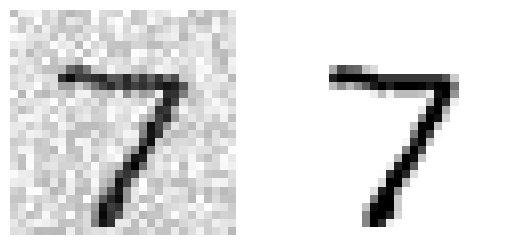

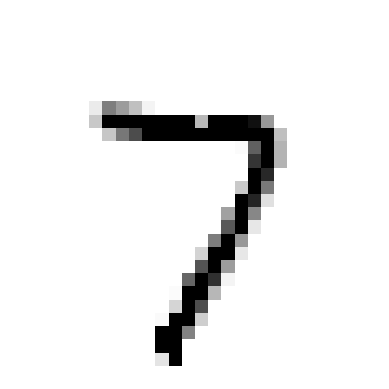

In [102]:
def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")
# extra code – this cell generates and saves Figure 3–12
plt.subplot(121); plot_digit(X_test_mod[0])
plt.subplot(122); plot_digit(y_test_mod[0])
plt.show()


knn.fit(X_train_mod,y_train_mod)
clean_digit=knn.predict([X_test_mod[0]])
plot_digit(clean_digit)

In [103]:
#---------------------------done_-----------------------------------------